In [43]:
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import cv2
from pathlib import Path
import keras
import tensorflow_datasets as tfds
from keras import layers
from keras import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization , Input , Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from google.colab import drive
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.layers import Rescaling # New import
from keras.applications.inception_v3 import InceptionV3
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip
from tensorflow.keras.layers import LeakyReLU
import hashlib
from PIL import Image



def iou(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    union = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3)) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou_score)
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))





folder = '/content/drive/MyDrive/sss/images'
def natural_sort(item):
    numbers = re.findall(r'\d+', item)

    return int(numbers[-1]) if numbers else 0

folderb = '/content/drive/MyDrive/sss/masks'
def natural_sort(item):
    numbers = re.findall(r'\d+', item)

    return int(numbers[-1]) if numbers else 0

mask_list = []
image_list = []
for paths, dirs, files in os.walk(folder):
    for file in files:
             image_list.append(os.path.join(paths, file))
             image_list.sort(key = natural_sort )
for paths, dirs, files in os.walk(folderb):
    for file in files:
             mask_list.append(os.path.join(paths, file))
             mask_list.sort(key = natural_sort )


print(len(image_list))
print(len(mask_list))

image_list = [tf.keras.preprocessing.image.load_img(i) for i in image_list]
image_list = [tf.image.resize(i, (256, 256)) for i in image_list]

mask_list = [tf.keras.preprocessing.image.load_img(i) for i in mask_list]

mask_list = [tf.image.resize(i, (256, 256)) for i in mask_list]
mask_list = [tf.image.rgb_to_grayscale (i) for i in mask_list]

image_array = np.array([np.array(img) for img in image_list])
mask_array = np.array([np.array(mask)/255.0 for mask in mask_list])
mask_array = (mask_array > 0.5).astype(np.float32)
print(len(image_list))
print(len(mask_list))



ddata = tf.data.Dataset.from_tensor_slices((image_array,mask_array))



ddata = ddata.shuffle(buffer_size=300, seed=None)

train_size = int(0.8 * len(ddata))
val_size = len(ddata) - train_size
train_ds = ddata.take(train_size)
val_ds = ddata.skip(train_size).take(val_size)

train_ds = train_ds.batch(10)
val_ds = val_ds.batch(10)


from tensorflow.keras.optimizers import Adam
opti = Adam(learning_rate=1e-4)

1300
1300
1300
1300


In [44]:
from keras.applications import VGG19

base_model = VGG19(input_shape=(256, 256, 3),
                      include_top=False,
                      weights='imagenet')

base_model.trainable = True
dice_loss = tf.keras.losses.Dice(
    reduction='sum_over_batch_size', name='dice'
)
base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.5 * dice + 0.5 * bce

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 64s 439ms/step - iou: 0.1760 - loss: 0.4106 - val_iou: 0.0638 - val_loss: 0.5047
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 412ms/step - iou: 0.4768 - loss: 0.2104 - val_iou: 0.1118 - val_loss: 0.4659
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 416ms/step - iou: 0.4908 - loss: 0.1967 - val_iou: 0.2084 - val_loss: 0.3511
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 416ms/step - iou: 0.5415 - loss: 0.1761 - val_iou: 0.0591 - val_loss: 0.5023
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 416ms/step - iou: 0.5247 - loss: 0.1790 - val_iou: 0.2358 - val_loss: 0.3486
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 415ms/step - iou: 0.5825 - loss: 0.1474 - val_iou: 0.3193 - val_loss: 0.2833
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 416ms/step - iou: 0.5772 - loss: 0.1536 - val_iou: 0.3596 - val_loss: 0.2475
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 416ms/step - iou: 0.6242 - loss: 0.1295 - val_iou: 0.4526 - val_loss: 0.1964
Epoch 9/100
104/104 ━━━━

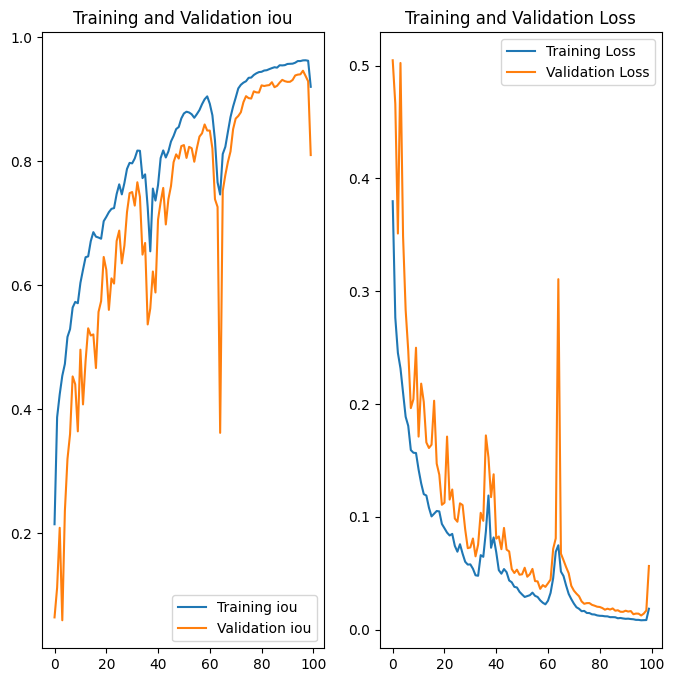

In [46]:
input = Input(shape=(256,256,3))
input = Rescaling(1./255, input_shape=(256,256,3))(input)



a = layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(input)
b = layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', activation= mish)(a)
c = layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(b)
d = BatchNormalization()(c)
e = max_pool_2d = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(d)

f = layers.Conv2D(128, 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(e)
g = layers.Conv2D(128, 3, padding='same',kernel_initializer='he_normal', activation= mish )(f)
h = layers.Conv2D(128, 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(g)
i = BatchNormalization()(h)
j = max_pool_2d = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(i)

k = layers.Conv2D(256, 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(j)
l = layers.Conv2D(256, 3, padding='same',kernel_initializer='he_normal', activation= mish)(k)
m = layers.Conv2D(256, 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(l)
n = BatchNormalization()(m)
o = max_pool_2d = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(n)

p = layers.Conv2D(512 , 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(o)
q = layers.Conv2D(512 , 3, padding='same',kernel_initializer='he_normal', activation= mish)(p)
r = layers.Conv2D(512 , 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(q)
s = BatchNormalization()(r)
t = max_pool_2d = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(r)


u = layers.Conv2D(1024 , 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(t)
v = layers.Conv2D(1024 , 3, padding='same',kernel_initializer='he_normal', activation= mish )(u)
w = layers.Conv2D(1024 , 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(v)


x = layers.Conv2DTranspose(  512,  3 ,  strides=(2, 2),  padding="same" )(w)
y = layers.concatenate([x,s])
z = layers.Conv2D(512 , 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(y)
z = layers.Conv2D(512 , 3, padding='same',kernel_initializer='he_normal', activation=  mish )(z)
a_1 = layers.Conv2D(512 , 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(z)

b_1 = layers.Conv2DTranspose(  256,  3 ,  strides=(2, 2),  padding="same" )(a_1)
c_1 = layers.concatenate([b_1,n])
d_1 = layers.Conv2D(256 , 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(c_1)
e_1 = layers.Conv2D(256 , 3, padding='same',kernel_initializer='he_normal', activation= mish )(d_1)
f_1 = layers.Conv2D(256 , 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(e_1)

g_1 = layers.Conv2DTranspose(  128,  3 ,  strides=(2, 2),  padding="same" )(e_1)
h_1 = layers.concatenate([g_1,i])
i_1 = layers.Conv2D(128 , 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(h_1)
j_1 = layers.Conv2D(128 , 3, padding='same',kernel_initializer='he_normal', activation=  mish )(i_1)
k_1 = layers.Conv2D(128 , 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(j_1)

l_1 = layers.Conv2DTranspose(  64,  3 ,  strides=(2, 2),  padding="same" )(k_1)
m_1 = layers.concatenate([l_1,d])
n_1 = layers.Conv2D(64 , 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(m_1)
o_1 = layers.Conv2D(64 , 3, padding='same',kernel_initializer='he_normal', activation=  mish )(n_1)
p_1 = layers.Conv2D(64 , 3, padding='same',kernel_initializer='he_normal', activation= 'leaky_relu')(o_1)


outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(p_1)
model = keras.Model(inputs=input, outputs=outputs)

epochs=100
model.compile(optimizer=opti,
              loss= combined_loss  ,
              metrics=[iou])
history = model.fit(
  train_ds,
  validation_data=val_ds,
   epochs=epochs )
acc = history.history['iou']
val_acc = history.history['val_iou']

loss = history.history['loss']
val_loss = history.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training iou')
plt.plot( val_acc, label='Validation iou')
plt.legend(loc='lower right')
plt.title('Training and Validation iou')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
model.save( '/content/drive/MyDrive/model/modele.keras')